In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # !rm /content/model_init_2021-08-0819_16_21.600083
# %rm -rf "/content/model_init_2021-08-0914_42_24.458958"

In [ ]:
# Unzip the files
!unzip "/content/drive/MyDrive/Project_data.zip" -d /content/


Archive:  /content/drive/MyDrive/Project_data.zip
replace /content/Project_data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# Importing the needed Libraries
import numpy as np
import os
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install scipy==1.2
from scipy.misc import imread, imresize

In [4]:
#
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

import cv2
import matplotlib.pyplot as plt
# % matplotlib inline

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

read the folder names for training and validation and set the batch size accordingly based on the system resources


In [5]:
# Setting train and val paths
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `input_height`,`input_width` and normalization such that you get high accuracy.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [input_frames for input_frames in range(0, input_frames)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(input_height, input_width, channels))

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(input_height, input_width, channels))

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


After writing the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [7]:
def train(batch_size, num_epochs, model, train_generator, val_generator, optimiser=None):
    curr_dt_time = datetime.datetime.now()

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print('# batch size =', batch_size)    
    print('# epochs =', num_epochs)

    #write your optimizer
    if optimiser == None:
        optimiser = Adam() # default learning rate = 0.001
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=1, verbose=1)
    
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=20,verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                callbacks=callbacks_list, validation_data=val_generator, 
                                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

Plotting:
Helper function to plot the training/validation accuracies/losses.

In [11]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    
    # summarize history for loss
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    # summarize history for accuracy
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Model 1 : Experiment 1
Initializing the model with Conv 3D neural network.

In [12]:
input_frames = 18
input_height = 84
input_width = 84

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3


model_1 = Sequential()

model_1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(input_frames, input_height, input_width, channels), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_1.add(Flatten())
model_1.add(Dense(1000, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(500, activation='relu'))
model_1.add(Dropout(0.5))

#softmax layer
model_1.add(Dense(classes, activation='softmax'))

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
# Setting the batch size, epochs and compiling the model.
batch_size = 30
num_epochs = 20

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_1 = train(batch_size, num_epochs, model_1, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 18, 84, 84, 8)     656       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 84, 84, 8)     32        
_________________________________________________________________
activation (Activation)      (None, 18, 84, 84, 8)     0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 42, 42, 8)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 9, 42, 42, 16)     3472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 42, 42, 16)     64        
__________________________________

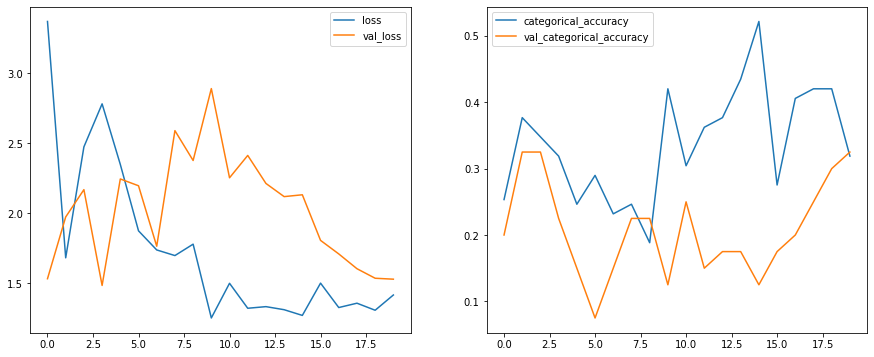

In [ ]:
plot(history_1)

2D CNN with LSTM

In [13]:
input_frames = 16
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3

model_2 = Sequential()

model_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(input_frames, input_height, input_width, channels)))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))


model_2.add(TimeDistributed(Flatten()))


model_2.add(LSTM(128))
model_2.add(Dropout(0.5))
        
model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.5))
        
model_2.add(Dense(classes, activation='softmax'))

In [14]:
def generator_augment(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [input_frames for input_frames in range(0, input_frames)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = np.zeros((batch_size, input_frames, input_height, input_width, channels))

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(input_height, input_width,3))
                    
                    M = cv2.getRotationMatrix2D((input_width//2, input_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (input_width, input_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
#                 batch_data=np.concatenate([batch_data,batch_data_aug])
#                 batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data_aug, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = np.zeros((batch_size, input_frames, input_height, input_width, channels))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(input_height,input_width,3))
                    
                    M = cv2.getRotationMatrix2D((input_width//2,input_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (input_width, input_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
#                 batch_data=np.concatenate([batch_data,batch_data_aug])
#                 batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data_aug, batch_labels

In [15]:
batch_size = 30
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_2 = train(batch_size, num_epochs, model_2, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 25
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 30, 30, 32)    0         
________________________________

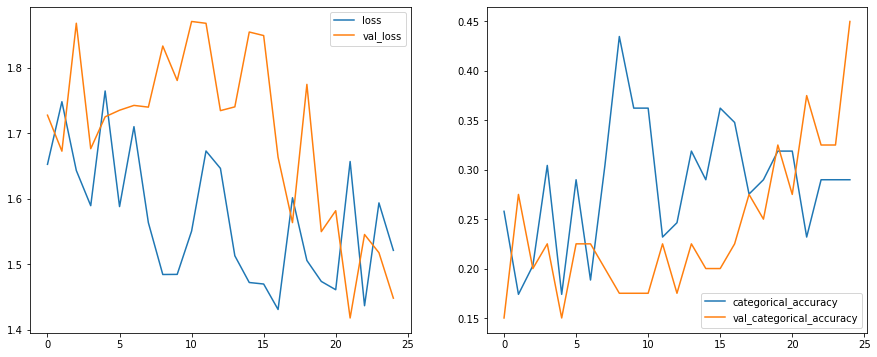

In [16]:
plot(history_2)